 # ETL Pipeline for Landing Strip Detection



 This script generates training data for landing strip detection by:

 1. Generating multiple input areas around each landing strip.

 2. Fetching satellite images for these input areas from Google Earth Engine.

 3. Creating label tensors indicating the presence of landing strips.

 4. Saving the images and labels to disk with appropriate naming conventions.



 **Note**: Ensure that you have authenticated with Google Earth Engine (GEE) using `ee.Authenticate()` and have initialized it with `ee.Initialize()`. Also, make sure `train_utils.py` is in your working directory or Python path.

 ## 1. Setup and Imports

In [1]:
# %%
import os
import sys
import random
import logging
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj
import torch
import ee
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import shapely

# Add the src directory to the sys.path if needed
sys.path.append(os.path.abspath('..'))

# Import functions and constants from train_utils
from secret_runway_detection.train_utils import (
    landing_strips_to_enclosing_input_areas,
    input_area_to_input_image,
    input_area_to_has_strip_tensor,
    get_time_period_of_strips_on_area,
    TILE_SIDE_LEN,
    TILES_PER_AREA_LEN,
    INPUT_IMAGE_HEIGHT,
    INPUT_IMAGE_WIDTH,
    RANDOM_SEED,
)


 ## 2. Configuration and Initialization

In [2]:
DEBUG = False

# Set parameters
NUM_INPUT_AREAS_PER_STRIP = 5 if not DEBUG else 1          # Input areas to generate per landing strip
NUM_POSSIBLY_EMPTY_AREAS = 5 if not DEBUG else 1            # Number of possibly empty areas to generate

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Dirs
OUTPUT_DIR = Path('../training_data')  # Directory to save the generated data
IMAGE_DIR = OUTPUT_DIR / 'images'
LABEL_DIR = OUTPUT_DIR / 'labels'
os.makedirs(IMAGE_DIR, exist_ok=True)
os.makedirs(LABEL_DIR, exist_ok=True)


 ## 3. Load Landing Strips Data

In [3]:
# %%
# Path to the landing strips shapefile
landing_strips_shp = '../pac_2024_training/pac_2024_training.shp'  # Update this path as needed

# Load the landing strips shapefile
landing_strips = gpd.read_file(landing_strips_shp)

if DEBUG:
    landing_strips = landing_strips.head(5)

# Ensure CRS is WGS84
if landing_strips.crs != 'EPSG:4326':
    landing_strips = landing_strips.to_crs('EPSG:4326')

# Ensure each landing strip has a unique ID
if 'id' not in landing_strips.columns:
    landing_strips['id'] = landing_strips.index

logger.info(f"Loaded {len(landing_strips)} landing strips.")


INFO:__main__:Loaded 154 landing strips.


 ## 4a. Generate Input Areas around Stripes and Fetch Data

In [4]:
# Initialize a counter for area indices
global_area_idx = 0

In [5]:
# Create the output directories if they don't exist
os.makedirs(IMAGE_DIR, exist_ok=True)
os.makedirs(LABEL_DIR, exist_ok=True)


# Loop over landing strips
for idx, strip in tqdm(landing_strips.iterrows(), total=len(landing_strips), desc="Processing Landing Strips"):
    strip_id = strip['id']
    logger.info(f"Processing landing strip {strip_id}")
    strip_geom = strip.geometry

    # Create a GeoDataFrame with just this strip
    strip_gdf = gpd.GeoDataFrame([strip], crs=landing_strips.crs)

    # Generate NUM_INPUT_AREAS_PER_STRIP input areas for this strip
    for area_idx in range(NUM_INPUT_AREAS_PER_STRIP):
        logger.info(f"Generating input area {area_idx + 1}/{NUM_INPUT_AREAS_PER_STRIP} for landing strip {strip_id}")

        # Generate input area around the strip
        input_areas = landing_strips_to_enclosing_input_areas(
            landing_strips=strip_gdf,
            num_tiles_per_area_side_len=TILES_PER_AREA_LEN,
            tile_side_len=TILE_SIDE_LEN
        )
        input_area = input_areas.iloc[0].geometry  # Get the generated input area

        # Get the time period for the area
        try:
            start_timestamp, end_timestamp = get_time_period_of_strips_on_area(
                strips=strip_gdf,
                area=input_area,
                area_crs=landing_strips.crs
            )
        except ValueError as e:
            logger.warning(f"Skipping area due to error in time period determination: {e}")
            continue

        # Fetch satellite image for the input area
        input_image = input_area_to_input_image(
            input_area=input_area,
            image_data_start_date=start_timestamp,
            image_data_end_date=end_timestamp,
            input_area_crs=landing_strips.crs,
            input_image_width=INPUT_IMAGE_WIDTH,
            input_image_height=INPUT_IMAGE_HEIGHT
        )

        # If the image is empty, skip this area
        if np.all(input_image == 0):
            logger.warning(f"No image data retrieved for area {area_idx} of landing strip {strip_id}. Skipping.")
            continue

        # Create label tensor
        label_tensor = input_area_to_has_strip_tensor(
            landing_strips=landing_strips,
            input_area=input_area,
            input_area_crs=landing_strips.crs,
            tiles_per_area_len=TILES_PER_AREA_LEN
        )

        # Save the image and label
        filename_base = f'area_{global_area_idx}_of_strip_{strip_id}'
        image_filename = IMAGE_DIR / f'{filename_base}.npy'
        label_filename = LABEL_DIR / f'{filename_base}.npy'

        np.save(image_filename, input_image)
        np.save(label_filename, label_tensor.numpy())

        logger.info(f"Saved image and label for area {area_idx} of landing strip {strip_id} as {filename_base}.npy")

        # Increment the global area index
        global_area_idx += 1


## 4b. Generate and Fetch Input Areas with No Strips

In [6]:

# Function to get the appropriate UTM CRS based on latitude and longitude
def get_utm_crs(latitude, longitude):
    utm_zone = int((longitude + 180) / 6) + 1
    hemisphere = 'north' if latitude >= 0 else 'south'
    return pyproj.CRS(f"+proj=utm +zone={utm_zone} +{hemisphere} +datum=WGS84 +units=m +no_defs")

# Initialize CRS
wgs84 = pyproj.CRS('EPSG:4326')

logger.info(f"Generating {NUM_POSSIBLY_EMPTY_AREAS} possibly empty areas by moving existing areas north.")

for idx in tqdm(range(NUM_POSSIBLY_EMPTY_AREAS), desc="Generating Possibly Empty Areas"):
    # Randomly select a landing strip
    strip = landing_strips.sample(1).iloc[0]
    strip_id = strip['id']
    strip_geom = strip.geometry

    # Generate input area around the strip
    input_areas = landing_strips_to_enclosing_input_areas(
        landing_strips=gpd.GeoDataFrame([strip], crs=landing_strips.crs),
        num_tiles_per_area_side_len=TILES_PER_AREA_LEN,
        tile_side_len=TILE_SIDE_LEN
    )
    input_area = input_areas.iloc[0].geometry  # Get the generated input area

    # Get centroid coordinates for UTM zone determination
    centroid = input_area.centroid
    utm_crs = get_utm_crs(centroid.y, centroid.x)

    # Convert input area to UTM for accurate distance translation
    input_area_utm = gpd.GeoSeries([input_area], crs=wgs84).to_crs(utm_crs).iloc[0]

    # Random distance between -100 km and 100 km
    distance_km = random.uniform(-100, 100)
    distance_m = distance_km * 1000  # Convert km to meters

    # Move the area north by the random distance
    moved_area_utm = shapely.affinity.translate(input_area_utm, xoff=0, yoff=distance_m)

    # Transform back to WGS84
    moved_area_wgs84 = gpd.GeoSeries([moved_area_utm], crs=utm_crs).to_crs(wgs84).iloc[0]

    # Fetch satellite image for the moved area
    try:
        # Use a fixed date range where imagery is available
        image_data_start_date = '2020-01-01'
        image_data_end_date = '2021-01-01'

        input_image = input_area_to_input_image(
            input_area=moved_area_wgs84,
            image_data_start_date=image_data_start_date,
            image_data_end_date=image_data_end_date,
            input_area_crs=wgs84,
            input_image_width=INPUT_IMAGE_WIDTH,
            input_image_height=INPUT_IMAGE_HEIGHT
        )
    except Exception as e:
        logger.warning(f"Skipping area due to error in image retrieval: {e}")
        continue

    # If the image is empty, skip this area
    if np.all(input_image == 0):
        logger.warning(f"No image data retrieved for possibly empty area {idx}. Skipping.")
        continue

    # Create label tensor (should be mostly zeros)
    label_tensor = input_area_to_has_strip_tensor(
        landing_strips=landing_strips,
        input_area=moved_area_wgs84,
        input_area_crs=wgs84,
        tiles_per_area_len=TILES_PER_AREA_LEN
    )

    # Save the image and label
    filename_base = f'area_{global_area_idx}_possibly_empty'
    image_filename = IMAGE_DIR / f'{filename_base}.npy'
    label_filename = LABEL_DIR / f'{filename_base}.npy'

    np.save(image_filename, input_image)
    np.save(label_filename, label_tensor.numpy())

    logger.info(f"Saved possibly empty image and label as {filename_base}.npy")

    # Increment the global area index
    global_area_idx += 1

INFO:__main__:Generating 5 possibly empty areas by moving existing areas north.


Generating Possibly Empty Areas:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:secret_runway_detection.train_utils:Total overlapping areas: 0
INFO:__main__:Saved possibly empty image and label as area_0_possibly_empty.npy
INFO:secret_runway_detection.train_utils:Total overlapping areas: 0
INFO:__main__:Saved possibly empty image and label as area_1_possibly_empty.npy
INFO:secret_runway_detection.train_utils:Total overlapping areas: 0
INFO:__main__:Saved possibly empty image and label as area_2_possibly_empty.npy
INFO:secret_runway_detection.train_utils:Total overlapping areas: 0
INFO:__main__:Saved possibly empty image and label as area_3_possibly_empty.npy
INFO:secret_runway_detection.train_utils:Total overlapping areas: 0
INFO:__main__:Saved possibly empty image and label as area_4_possibly_empty.npy


 ## 5. Visualize Sample Data (Optional)

In [26]:
import matplotlib.colors as mcolors

def plot_satellite_with_tensor_grid(satellite_image: np.ndarray, has_strip_tensor: torch.Tensor):
    """
    Plots the satellite image with a grid overlay indicating landing strip presence.

    Parameters:
    - satellite_image (np.ndarray): Satellite image array with shape (C, H, W).
    - has_strip_tensor (torch.Tensor): Tensor indicating landing strip presence in each tile.
    - tiles_per_area_len (int): Number of tiles per side.
    """
    # Convert satellite_image from (C, H, W) to (H, W, C) for plotting
    satellite_image_rgb = np.transpose(satellite_image, (1, 2, 0))
    
    # Normalize the image for display (assuming values are between 0 and 1)
    satellite_image_rgb = np.clip(satellite_image_rgb, 0, 1)
    
    # Create a figure
    plt.figure(figsize=(10, 10))
    
    # Display the satellite image
    plt.imshow(satellite_image_rgb)
    
    # Overlay the has_strip tensor
    if isinstance(has_strip_tensor, torch.Tensor):
        has_strip_np = has_strip_tensor.numpy()
    else:
        has_strip_np = has_strip_tensor

    cmap = mcolors.ListedColormap(['none', 'red'])
    bounds = [0, 0.5, 1]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    # Plot the tensor as a semi-transparent overlay
    plt.imshow(
        has_strip_np, 
        cmap=cmap, 
        alpha=0.3, 
        interpolation='nearest',
        extent=[0, satellite_image_rgb.shape[1], satellite_image_rgb.shape[0], 0],
        # vmin=0.1  # Ensures that 0 values are transparent
    )
    
    # Remove axes
    plt.axis('off')
    
    # Add title
    plt.title('Satellite Image with Landing Strip Grid Overlay')
    
    # Show the plot
    plt.show()

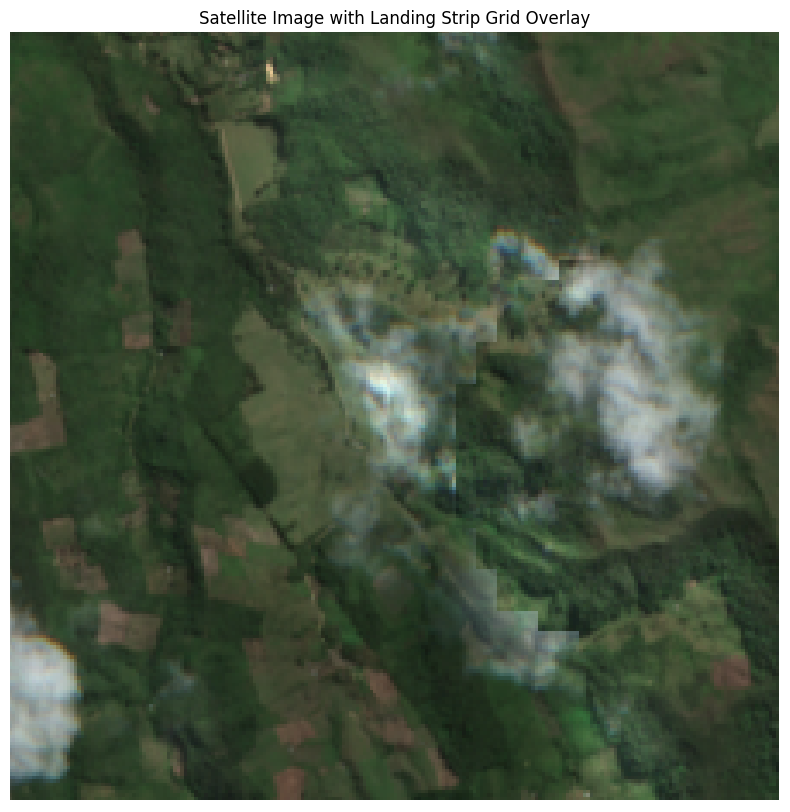

In [36]:
# List all image files
image_files = sorted(IMAGE_DIR.glob('*.npy'))
label_files = sorted(LABEL_DIR.glob('*.npy'))

# Check if there are any files to display
if image_files and label_files:
    # Select a random sample
    sample_idx = random.randint(0, len(image_files) - 1)
    sample_image_path = image_files[sample_idx]
    sample_label_path = label_files[sample_idx]

    # Load the sample image and label
    sample_image = np.load(sample_image_path)
    sample_label = np.load(sample_label_path)
    
    # Plot the satellite image with has_strip tensor grid overlay
    plot_satellite_with_tensor_grid(
        satellite_image=sample_image,
        # satellite_image=np.ones(satellite_image.shape),
        has_strip_tensor=sample_label,
    )
else:
    logger.warning("No image or label files found for visualization.")


 ## 6. Summary

In [9]:
logger.info("ETL process completed. Training data saved to disk.")

INFO:__main__:ETL process completed. Training data saved to disk.
